In [15]:
from google.colab import files
uploaded = files.upload()


import pandas as pd


train_features = pd.read_csv('dataset/training_set_features.csv')
train_labels = pd.read_csv('dataset/training_set_labels.csv')
test_features = pd.read_csv('dataset/test_set_features.csv')


Saving test_set_features.csv to test_set_features (2).csv
Saving training_set_features.csv to training_set_features (2).csv
Saving training_set_labels.csv to training_set_labels (2).csv


In [16]:
print(train_features.head())
print(train_labels.head())
print(test_features.head())

   respondent_id  xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0              0          1.0            0.0                        0.0   
1              1          3.0            2.0                        0.0   
2              2          1.0            1.0                        0.0   
3              3          1.0            1.0                        0.0   
4              4          2.0            1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0  

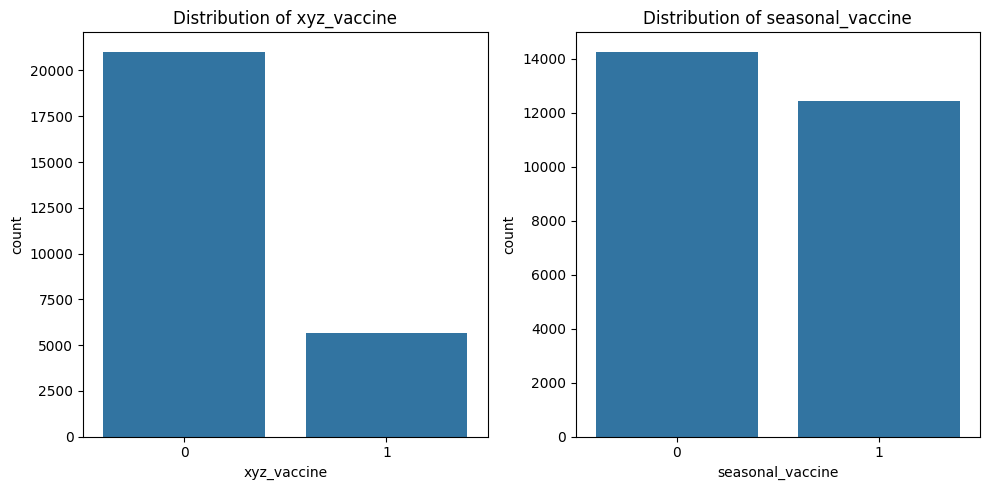

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='xyz_vaccine', data=train_labels)
plt.title('Distribution of xyz_vaccine')

plt.subplot(1, 2, 2)
sns.countplot(x='seasonal_vaccine', data=train_labels)
plt.title('Distribution of seasonal_vaccine')

plt.tight_layout()
plt.show()


In [21]:
# Check for missing values
print(train_features.isnull().sum())
print(test_features.isnull().sum())

# Fill missing values for numerical columns
numerical_cols = train_features.select_dtypes(include=['int64', 'float64']).columns
train_features[numerical_cols] = train_features[numerical_cols].fillna(train_features[numerical_cols].median())
test_features[numerical_cols] = test_features[numerical_cols].fillna(test_features[numerical_cols].median())

# Encode categorical variables using one-hot encoding
categorical_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty',
                    'marital_status', 'rent_or_own', 'employment_status',
                    'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']

train_features = pd.get_dummies(train_features, columns=categorical_cols, drop_first=True)
test_features = pd.get_dummies(test_features, columns=categorical_cols, drop_first=True)

# Ensure the same columns in train and test set
train_features, test_features = train_features.align(test_features, join='left', axis=1, fill_value=0)


respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

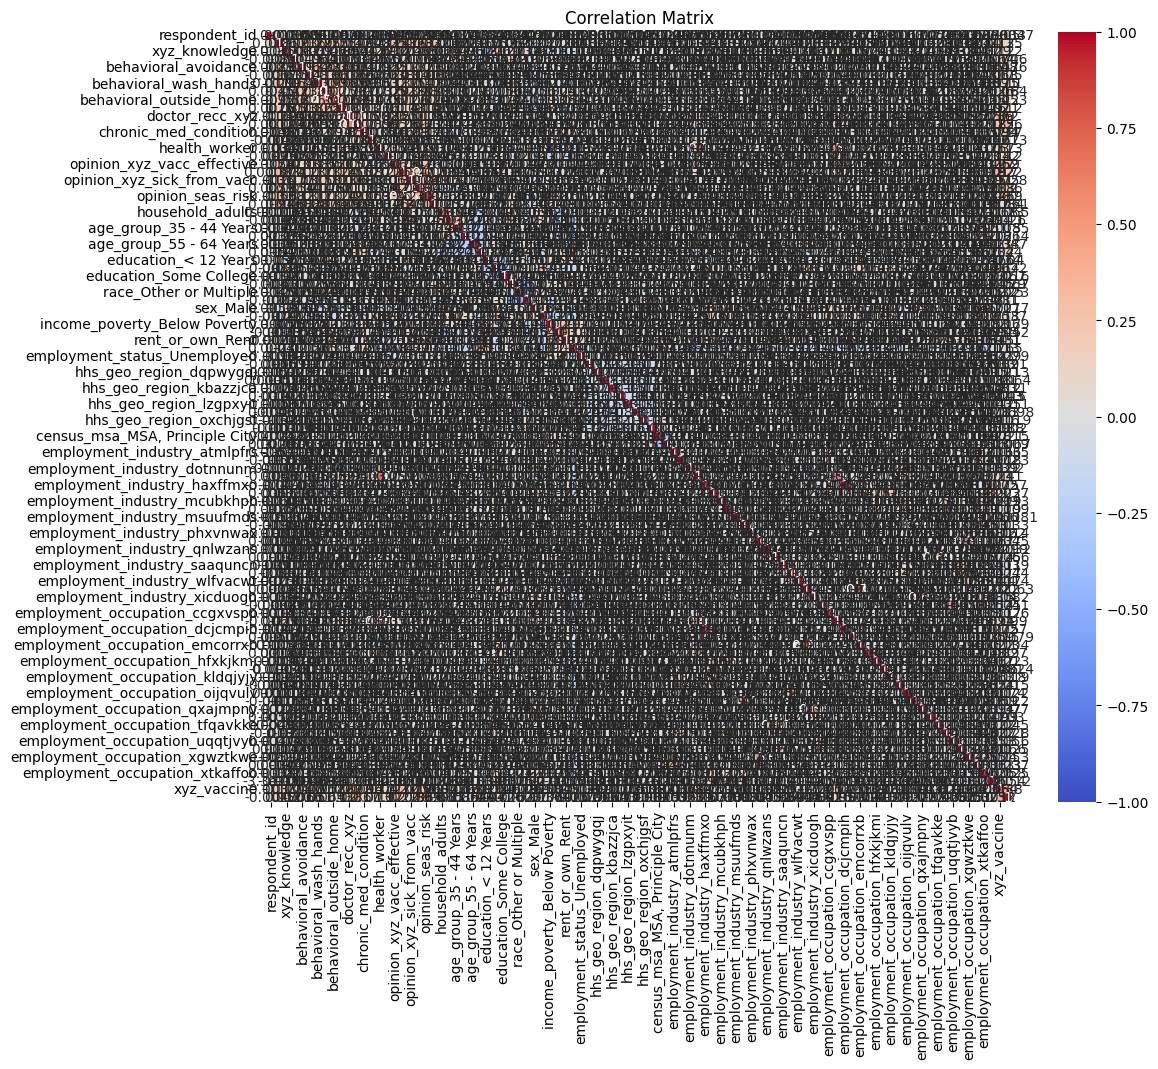

In [22]:
# Merge features and labels
train_full = pd.merge(train_features, train_labels, on='respondent_id')

# Calculate correlation matrix
corr_matrix = train_full.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Split data into training and validation sets
X = train_features.drop('respondent_id', axis=1)
y = train_labels[['xyz_vaccine', 'seasonal_vaccine']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest Model
clf_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf_rf.fit(X_train, y_train)

# Logistic Regression Model
clf_lr = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))
clf_lr.fit(X_train, y_train)

# Evaluate RandomForest Model
y_pred_rf = clf_rf.predict_proba(X_val)
y_pred_rf = pd.DataFrame({
    'xyz_vaccine': [pred[1] for pred in y_pred_rf[0]],
    'seasonal_vaccine': [pred[1] for pred in y_pred_rf[1]]
})

roc_auc_xyz_rf = roc_auc_score(y_val['xyz_vaccine'], y_pred_rf['xyz_vaccine'])
roc_auc_seasonal_rf = roc_auc_score(y_val['seasonal_vaccine'], y_pred_rf['seasonal_vaccine'])
mean_roc_auc_rf = (roc_auc_xyz_rf + roc_auc_seasonal_rf) / 2

print(f'RandomForest ROC AUC for xyz_vaccine: {roc_auc_xyz_rf}')
print(f'RandomForest ROC AUC for seasonal_vaccine: {roc_auc_seasonal_rf}')
print(f'RandomForest Mean ROC AUC: {mean_roc_auc_rf}')

# Evaluate Logistic Regression Model
y_pred_lr = clf_lr.predict_proba(X_val)
y_pred_lr = pd.DataFrame({
    'xyz_vaccine': [pred[1] for pred in y_pred_lr[0]],
    'seasonal_vaccine': [pred[1] for pred in y_pred_lr[1]]
})

roc_auc_xyz_lr = roc_auc_score(y_val['xyz_vaccine'], y_pred_lr['xyz_vaccine'])
roc_auc_seasonal_lr = roc_auc_score(y_val['seasonal_vaccine'], y_pred_lr['seasonal_vaccine'])
mean_roc_auc_lr = (roc_auc_xyz_lr + roc_auc_seasonal_lr) / 2

print(f'Logistic Regression ROC AUC for xyz_vaccine: {roc_auc_xyz_lr}')
print(f'Logistic Regression ROC AUC for seasonal_vaccine: {roc_auc_seasonal_lr}')
print(f'Logistic Regression Mean ROC AUC: {mean_roc_auc_lr}')


RandomForest ROC AUC for xyz_vaccine: 0.8278567766768357
RandomForest ROC AUC for seasonal_vaccine: 0.8524855412363895
RandomForest Mean ROC AUC: 0.8401711589566125
Logistic Regression ROC AUC for xyz_vaccine: 0.8316634310734606
Logistic Regression ROC AUC for seasonal_vaccine: 0.8558120341678567
Logistic Regression Mean ROC AUC: 0.8437377326206587


In [25]:
# Choose the better performing model
if mean_roc_auc_rf > mean_roc_auc_lr:
    clf_best = clf_rf
else:
    clf_best = clf_lr

# Predict on the test set
test_X = test_features.drop('respondent_id', axis=1)
test_pred = clf_best.predict_proba(test_X)

# Prepare submission
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': [pred[1] for pred in test_pred[0]],
    'seasonal_vaccine': [pred[1] for pred in test_pred[1]]
})

# Save to CSV
submission.to_csv('result.csv', index=False)
